In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import default_rng
#import seaborn as sns
#sns.set()

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 14})

In [3]:
talko_scratch = 'talko3'

In [4]:
files1 = os.listdir(os.path.join(talko_scratch, 'data1'))
files2 = os.listdir(os.path.join(talko_scratch, 'data2'))
files3 = os.listdir(os.path.join(talko_scratch, 'data3'))

In [5]:
talko3_files = files1 + files2 + files3
talko3_txt = os.listdir(os.path.join(talko_scratch, 'txt'))

In [1]:
#talko_speaker_df = pd.read_csv('talko3_speaker_info.csv')
#talko_speaker_df['recording_year'] = talko_speaker_df['recording_year'].astype(pd.Int64Dtype())
#talko_speaker_df['birth_year'] = talko_speaker_df['birth_year'].astype(pd.Int64Dtype())
#talko_speaker_df.dtypes

In [9]:
talko_speaker_df.speaker.unique().size

469

In [10]:
talko_speaker_df.recording_year.min()

1958

In [11]:
talko_speaker_df[talko_speaker_df.gender == 'man'].speaker.unique().size

214

In [12]:
talko_speaker_df[talko_speaker_df.gender == 'woman'].speaker.unique().size

255

In [13]:
talko_speaker_df['birth_decade'] = ((talko_speaker_df['birth_year'] / 10).astype(pd.Int64Dtype()) * 10) #.astype(pd.Int64Dtype())
talko_speaker_df['birth_decade'].dtype

talko_speaker_df['recording_decade'] = ((talko_speaker_df['recording_year'] / 10).astype(pd.Int64Dtype()) * 10) #.astype(pd.Int64Dtype())
talko_speaker_df['recording_decade'].dtype

talko_speaker_df['speaker_age'] = talko_speaker_df['recording_year'].astype(pd.Int64Dtype()) - talko_speaker_df['birth_year'].astype(pd.Int64Dtype()) #.astype(pd.Int64Dtype())
talko_speaker_df['speaker_age_tens'] = ((talko_speaker_df['speaker_age'] / 10).astype(pd.Int64Dtype()) * 10) #.astype(pd.Int64Dtype())

<AxesSubplot:xlabel="Speaker's age group">

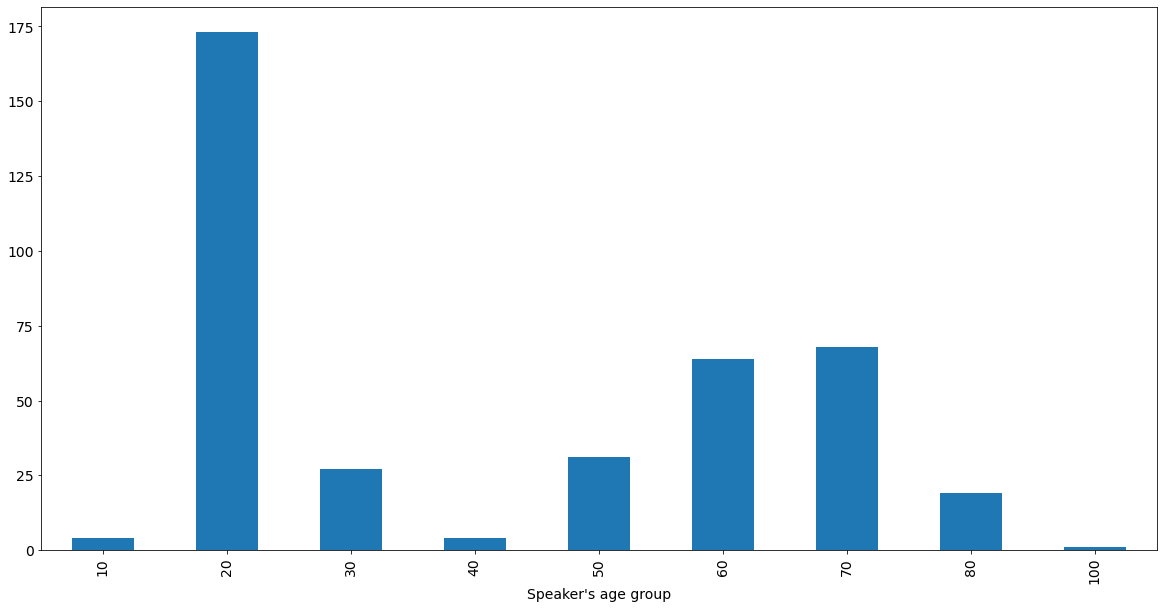

In [14]:
talko_speaker_df.groupby('speaker_age_tens').size().plot(kind='bar', xlabel="Speaker's age group")

<AxesSubplot:xlabel="Speaker's decade of birth">

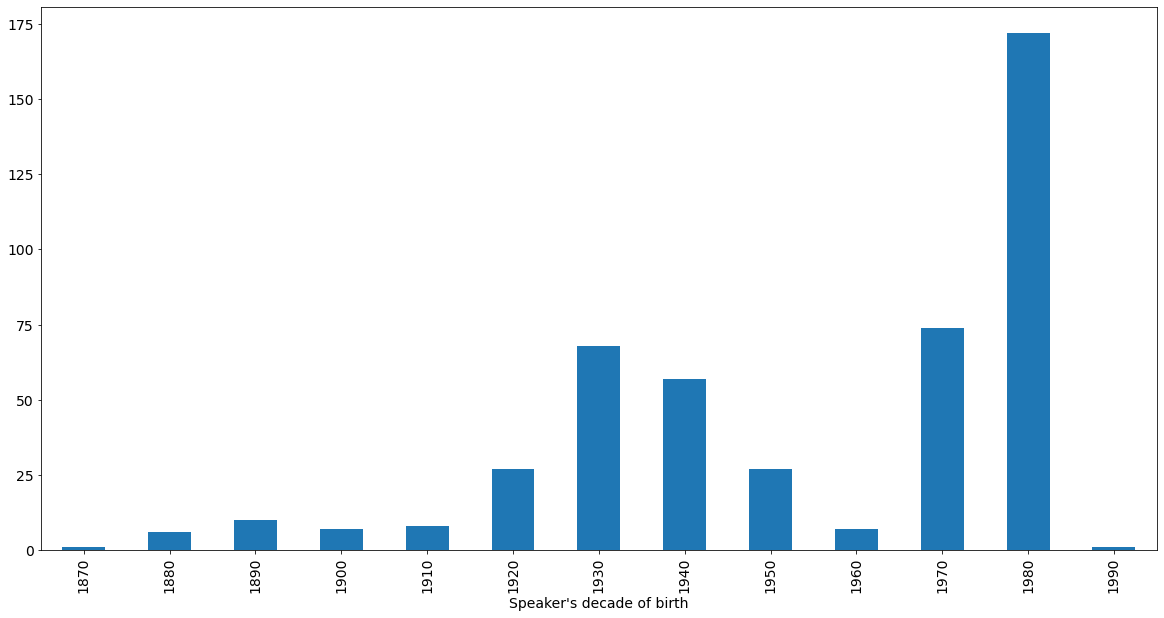

In [15]:
talko_speaker_df.groupby('birth_decade').size().plot(kind='bar', xlabel="Speaker's decade of birth")

<AxesSubplot:xlabel='Decade of recording'>

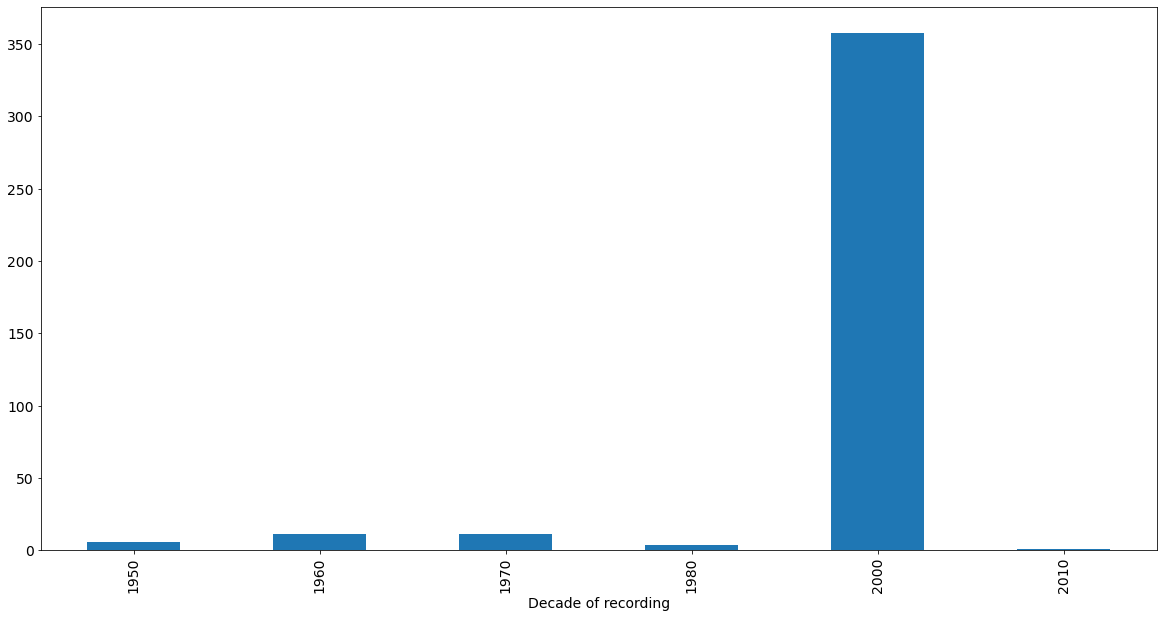

In [16]:
talko_speaker_df.groupby('recording_decade').size().plot(kind='bar', xlabel="Decade of recording")

In [17]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as MD

In [18]:
def get_speakers(root):
    speakers = {}
    for speaker in root.iter('Speaker'):
        speaker_id = speaker.attrib['id']
        speaker_attrib = dict(speaker.attrib)
        for key in speaker_attrib.keys():
            speaker_attrib[key] = speaker_attrib[key].strip()
        del speaker_attrib['id']
        speakers[speaker_id] = speaker_attrib
    return speakers

def get_topics(root):
    topics = {}
    for topic in root.iter('Topic'):
        topic_id = topic.attrib['id']
        topic_attrib = dict(topic.attrib)
        del topic_attrib['id']
        topics[topic_id] = topic_attrib
    return topics

def process_stringlist(strings):
    strings = [s.strip() for s in strings]
    strings = list(filter(None, strings))
    return strings
    
def parse_synced_text(strlist):
    beginning_token_i = strlist.index('<Sync')
    sync = {}
    end_token_i = 0
    for i in range(beginning_token_i + 1, len(strlist)):
        if strlist[i] == '/>':
            end_token_i = i
            break
        if '=' in strlist[i]:
            p = strlist[i].split('=')
            p = [part.replace('"', '') for part in p]
            sync[p[0]] = p[1]
    string_content = strlist[end_token_i + 1:]
    if '<Sync' in string_content:
        next_sync_token = string_content.index('<Sync')
        next_sync = string_content[next_sync_token:]
        string_content = string_content[0:next_sync_token]
        return {'time': sync['time'], 'text': string_content}, next_sync
    return {'time': sync['time'], 'text': string_content}, None

def get_utts_from_synced_text(str_list, utt_end_time):
    rest = str_list
    synced_texts = []
    while not rest == None:
        sync, rest = parse_synced_text(rest)
        synced_texts.append(sync)
    utts = []
    for i in range(len(synced_texts)):
        sync = synced_texts[i]
        if i + 1 < len(synced_texts):
            utts.append({
                'start_time': sync['time'],
                'end_time': synced_texts[i + 1]['time'],
                'text': ' '.join(sync['text'])
            })
        else:
            utts.append({
                'start_time': sync['time'],
                'end_time': utt_end_time,
                'text': ' '.join(sync['text'])
            })
    return utts

def parse_turn_tokens(strlist):
    beginning_token_i = strlist.index('<Turn')
    turn = {}
    end_token_i = 0
    for i in range(beginning_token_i, len(strlist)):
        if strlist[i] == '>':
            end_token_i = i
            break
        if '=' in strlist[i]:
            p = strlist[i].split('=')
            p = [part.replace('"', '') for part in p]
            turn[p[0]] = p[1]
    turn_end_token = strlist.index('</Turn>')
    return turn, strlist[end_token_i + 1: turn_end_token]

def remove_simple_token(strlist, starting_token):
    start_i = None
    end_i = None
    token = {}    
    for i in range(len(strlist)):
        if strlist[i] == starting_token:
            start_i = i
            for ii in range(i + 1, len(strlist)):
                if '=' in strlist[ii]:
                    p = strlist[ii].split('=')
                    p = [part.replace('"', '') for part in p]
                    token[p[0]] = p[1]
                if strlist[ii] == '/>':
                    end_i = ii
                    break
            break
    #print(event)
    #return strlist[0: start_i] + ['<UNK>'] + strlist[end_i + 1:]
    return strlist[0: start_i] + strlist[end_i + 1:], token

class Utterance:
    def __init__(self, file, speaker, text, start_time, end_time, section_type, section_start_time, section_end_time, section_topic, unclear):
        self.file = file
        self.speaker = speaker
        self.text = text
        self.start_time = start_time
        self.end_time = end_time
        self.section_type = section_type
        self.section_start_time = section_start_time
        self.section_end_time = section_end_time
        self.section_topic = section_topic
        self.unclear = unclear
    def to_dict(self):
        return {
            'file': self.file.strip(),
            'speaker': self.speaker['name'].strip(),
            'speaker_check': self.speaker['check'].strip(),
            'speaker_dialect': self.speaker['dialect'].strip(),
            'speaker_accent': self.speaker['accent'].strip(),
            'speaker_scope': self.speaker['scope'].strip(),
            'text': self.text.strip(),
            'start_time': self.start_time.strip(),
            'end_time': self.end_time.strip(),
            'section_type': self.section_type.strip(),
            'section_start_time': self.section_start_time.strip(),
            'section_end_time': self.section_end_time.strip(),
            'section_topic_desc': self.section_topic.strip(),
            'unclear': self.unclear
        }
    
def get_utterances(root, file, speakers, topics):
    utterances = []
    for episode in root.iter('Episode'):
        #print(episode.tag, episode.attrib)
        for section in episode.iter('Section'):
            #print(section.tag, section.attrib)
            section_attrib = dict(section.attrib)
            for turn in section.iter('Turn'):
                if (not 'speaker' in turn.attrib) or (not turn.attrib['speaker'] in speakers):
                    continue
                str_list = ET.tostringlist(turn, encoding='unicode', method='xml')
                str_list = process_stringlist(str_list)
                
                if '<Who' in str_list:
                    # Overlapping speech
                    continue
                
                turn_obj, str_list = parse_turn_tokens(str_list)
                
                #sync_obj, str_list = parse_sync_tokens(str_list)
                
                while '<Event' in str_list:
                    str_list, event = remove_simple_token(str_list, '<Event')
                
                unclear_speech = False
                while '<Comment' in str_list:
                    str_list, comment = remove_simple_token(str_list, '<Comment')
                    if (not unclear_speech) and (comment['desc'] == 'osäkert' or comment['desc'] == 'otydligt'):
                        unclear_speech = True
                
                assert str_list[0] == '<Sync'
                
                utts = get_utts_from_synced_text(str_list, turn_obj['endTime'])
                for utt in utts:
                    
                    if len(utt['text']) == 0:
                        continue
                    
                    section_topic = ''
                    if 'topic' in section_attrib:
                        section_topic = topics[section_attrib['topic']]['desc']
                    utterances.append(Utterance(file, speakers[turn_obj['speaker']], utt['text'], utt['start_time'], utt['end_time'], section_attrib['type'], section_attrib['startTime'], section_attrib['endTime'], section_topic, unclear_speech))
    return utterances
                
def parse_talko_file(file, trs_name):
    t = open(os.path.join(talko_scratch, 'txt', trs_name), 'rb')
    doc = ET.parse(t)
    root = doc
    speakers = get_speakers(root)
    topics = get_topics(root)
    utts = get_utterances(root, file, speakers, topics)
    t.close()
    return pd.DataFrame.from_records([utt.to_dict() for utt in utts])

In [19]:
alt_transcription_names = {'nykarleby landskommun_ym02_sp.wav': 'nykarlebyLK_ym02_sp-oversatt.trs',
                          'nykarleby landskommun_ym03_sp.wav': 'nykarlebyLK_ym03_sp-oversatt.trs'}

def parse_talko3_transcriptions():
    talko3_df_list = []
    for file in talko3_files:
        #print(file)
        trs_name = file.replace('.wav', '') + '-oversatt.trs'
        if file in alt_transcription_names:
            trs_name = alt_transcription_names[file]
        assert os.path.exists(os.path.join(talko_scratch, 'txt', trs_name))
        talko3_df_list.append(parse_talko_file(file, trs_name))
    return pd.concat(talko3_df_list)

In [20]:
talko3_df = parse_talko3_transcriptions()

In [21]:
unknown_speaker = 'ovrig_talare_sp'

In [22]:
def fill_talko3_speaker_information(df1, df2):
    return pd.merge(df1, df2, on="speaker", how='left')

In [23]:
talko3_merged_df = fill_talko3_speaker_information(talko3_df, talko_speaker_df)

In [24]:
# Empty utts
talko3_merged_df[talko3_merged_df.text == ''].shape[0] / talko3_merged_df.shape[0]

0.0

In [25]:
# Do something about empty utts (just ignore these) - DONE
# Analyze text - DONE
# Fill in missing region - DONE
# Analyze speakers, edit unknown speaker to several speakers - DONE
# epävarmat ehkä pois ??? - DONE

# Write Kaldi files
# Write uttlists for different splits (create testset)

In [26]:
def print_duration_stats(df_dur):
    durations = df_dur['end_time'].astype(float) - df_dur['start_time'].astype(float)
    print('total_length:', durations.sum() / 3600)
    print('longest:', durations.max())
    print('shortest:', durations.min())
    print('avg:', durations.mean())

In [27]:
talko3_merged_df.region.unique()

array(['Nyland', 'Åboland', 'Åland', 'Österbotten', nan, 'språköarna'],
      dtype=object)

In [28]:
def fill_in_missing_regions(df4):
    if not df4.region.isna().any(): return
    
    missing_regions = {}
    for file in df4[df4.region.isna()].file.unique():
        missing_regions[file] = ''

    for i, row in df4.iterrows():
        if row.file in missing_regions:
            if type(row.region) == str:
                missing_regions[row.file] = row.region
                
    for file in missing_regions:
        assert not missing_regions[file] == ''

    df4['region'] = df4.apply(lambda row: missing_regions[row['file']] if ((not type(row['region']) == str) and np.isnan(row['region'])) else row['region'], axis=1)

In [29]:
def manual_replacements(word):
    replacements = {'747': 'sju hundra fyrtiosju',
                    'mtv3': 'mtv tre',
                    '3': 'tre',
                    'a4': 'a fyra',
                    'm3a': 'm tre a',
                    'e3an': 'e tre an',
                    '3d': 'tre d',
                    'mp3': 'mp tre',
                    'tv4': 'tv fyra',
                    'that´s': 'thats',
                    'u23': 'u tjugo tre',
                    'x3m': 'x tre m',
                    'p1': 'p ett',
                    'n25': 'n tjugo fem',
                    'v8': 'v åtta',
                    '1': 'ett',
                    '386a': 'tre hundra åttio sex a',
                    'p3': 'p tre',
                    'tv4s': 'tv fyras',
                    'tw3': 'tw tre',
                    'can´t': 'cant',
                    'e3': 'e tre',
                    'rock´n´roll': 'rock n roll',
                    'p4': 'p fyra',
                    '1g3b': 'ett g tre b',
                    '4h': 'fyra h'}
    if word in replacements:
        return replacements[word]
    else:
        return word
    
def process_text(df5):
    non_alpha_words = set()
    processed_text = []
    for text in df5.text:
        text = text.lower()
        text = text.replace('-', ' ').strip()
        text = text.replace(':', '').strip()
        text = text.replace('§', '').strip()
        text = text.replace('(.)', '').strip()
        text = text.replace('(..)', '').strip()
        text = text.replace('(...)', '').strip()
        text = text.replace("'", '').strip()
        text = text.replace('/', '').strip()
        text = text.replace('î', 'i')
        text = text.replace('ñ', 'n')
        text = text.replace('rós', 'ros')
        new_words = []
        for word in text.split():
            word = word.strip()
            word = manual_replacements(word)
            new_words.append(word)
        processed_text.append(' '.join(new_words))
        for word in processed_text[-1].split():
            if not word.isalpha():
                non_alpha_words.append(word)
    if len(non_alpha_words) == 0:
        print('all words alphabetical')
    df5['processed_text'] = processed_text

In [30]:
def add_index_to_unknown_speakers(df6):
    if df6[df6.speaker == unknown_speaker].shape[0] == 0: return
    i = 0
    other_speaker_ids = {}
    for file in df6[df6.speaker == unknown_speaker].file.unique():
        other_speaker_ids[file] = 'other_speaker' + '_' + str(i)
        i += 1
    df6.speaker = df6.apply(lambda row: other_speaker_ids[row.file] if row.speaker == unknown_speaker else row.speaker, axis=1)

In [31]:
talko3_merged_df.unclear.value_counts()

False    86568
True         4
Name: unclear, dtype: int64

In [32]:
def generate_speaker_id(df7):
    speaker_id = []
    for spk in df7.speaker:
        speaker_id.append('SV-TAL-' + spk)
    df7['speaker_id'] = speaker_id
        
def generate_utterance_id(df8):
    utterance_ids = []
    for i, row in df8.iterrows():
        utterance_id = '-'.join([row.speaker_id, f'{i:05}'])
        utterance_ids.append(utterance_id)
    df8['utterance_id'] = utterance_ids

def generate_file_ids(df9):
    df9['file_id'] = [file[:-4] for file in df9.file]
    
def rename_nykarleby_files(df10):
    alt_filenames = {'nykarleby landskommun_ym02_sp.wav': 'nykarlebyLK_ym02_sp.wav',
                          'nykarleby landskommun_ym03_sp.wav': 'nykarlebyLK_ym03_sp.wav'}
    df10.file = df10.apply(lambda row: alt_filenames[row.file] if row.file in alt_filenames else row.file, axis=1)

In [33]:
def apply_changes(df11):
    fill_in_missing_regions(df11)
    process_text(df11)
    add_index_to_unknown_speakers(df11)
    
    generate_speaker_id(df11)
    generate_utterance_id(df11)
    rename_nykarleby_files(df11)
    generate_file_ids(df11)

In [36]:
apply_changes(talko3_merged_df)

all words alphabetical


In [37]:
print_duration_stats(talko3_merged_df)

total_length: 102.01406159035515
longest: 83.16300000000001
shortest: 0.013000000000001677
avg: 4.242140896886711


In [42]:
talko3_merged_df.columns

Index(['file', 'speaker', 'speaker_check', 'speaker_dialect', 'speaker_accent',
       'speaker_scope', 'text', 'start_time', 'end_time', 'section_type',
       'section_start_time', 'section_end_time', 'section_topic_desc',
       'unclear', 'birth_year', 'age_group', 'recording_year', 'gender',
       'participant_role', 'region', 'subregion', 'parish', 'collection',
       'education', 'birth_decade', 'processed_text', 'speaker_id',
       'utterance_id', 'file_id'],
      dtype='object')

In [53]:
def write_kaldi_files(df_final, talko3_16khz_mono_path):
    
    df_clear = df_final[df_final.unclear == False]
    
    with open('talko3/wav.scp', 'w') as f:
        for _, row in df_clear.drop_duplicates(subset=['file']).iterrows():
            f.write(' '.join([row.file_id, os.path.join(talko3_16khz_mono_path, row.file)]) + '\n')
        
    with open('talko3/text', 'w') as f:
        for _, row in df_clear.iterrows():
            f.write(' '.join([row.utterance_id, row.processed_text]) + '\n')
        
    with open('talko3/utt2spk', 'w') as f:
        for _, row in df_clear.iterrows():
            f.write(' '.join([row.utterance_id, row.speaker_id]) + '\n')
        
    with open('talko3/segments', 'w') as f:
        for _, row in df_clear.iterrows():
            f.write(' '.join([row.utterance_id, row.file_id, row.start_time, row.end_time]) + '\n')

In [54]:
#write_kaldi_files(talko3_merged_df, 'talko3/talko3_mono16khz')

In [147]:
def write_ark_creation_script(df_final):
    script_lines = []
    for file in df_final.file.unique():
        
        data_folder = None
        if os.path.exists(os.path.join(talko_scratch, 'data1', file)):
            data_folder = 'data1'
        if os.path.exists(os.path.join(talko_scratch, 'data2', file)):
            data_folder = 'data2'
        if os.path.exists(os.path.join(talko_scratch, 'data3', file)):
            data_folder = 'data3'
            
        full_filepath = os.path.join(talko_scratch, data_folder, file)
        script_lines.append("sox -t wav {full_filepath} -L -b 16 -r 16000 ./talko3_mono16khz/{filename} remix -\n".format(full_filepath=full_filepath, filename=file))
    
    with open('to_mono16khz.sh', 'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --time=01:00:00\n')
        f.write('#SBATCH --mem=128M\n')
        for line in script_lines:
            f.write(line)

In [148]:
write_ark_creation_script(talko3_merged_df)
# 86568 utts

In [58]:
talko3_merged_df['duration'] = talko3_merged_df['end_time'].astype(float) - talko3_merged_df['start_time'].astype(float)

In [61]:
talko3_merged_df.groupby('region').duration.sum() / 3600

region
Nyland         30.145378
språköarna      2.854346
Åboland        16.720632
Åland           8.961204
Österbotten    43.332502
Name: duration, dtype: float64

In [62]:
talko3_merged_df.to_csv('talko3.csv')

In [143]:
def get_random_subset(indices, size, rng):
    choice = rng.choice(range(indices.shape[0]), size=size, replace=False)    
    subset = np.zeros(indices.shape[0], dtype=bool)
    subset[choice] = True
    rest = ~subset
    return indices[subset], indices[rest]

def separate_dataset(df_final):
    rng = default_rng(seed=476397)
    
    train_sets = {}
    test_sets = {}
    test_set_sizes = {
        'Österbotten': 900,
        'Nyland': 900,
        'Åland': 900,
        'Åboland': 900,
        'språköarna': 200
    }
    
    test_set_total_length = 0
    train_set_total_length = 0
    for region in test_set_sizes.keys():
        region_indices = df_final[df_final.region == region].index
        test_i, train_i = get_random_subset(region_indices, test_set_sizes[region], rng)
        test = df_final[df_final.index.isin(test_i)]
        train = df_final[df_final.index.isin(train_i)]
        train_sets[region] = train
        test_sets[region] = test
        
        test_size = test.duration.sum() / 3600
        train_size = train.duration.sum() / 3600
        test_set_total_length += test_size
        train_set_total_length += train_size
        
        print('{} test set: {:.2f}h'.format(region, test_size))
        print('{} train set: {:.2f}h'.format(region, train_size))
    
    print()
    print('test set total size: {:.2f}h'.format(test_set_total_length))
    print('train set total size: {:.2f}h'.format(train_set_total_length))
    
    with open('talko3_test_utts', 'w') as f:
        for region in test_set_sizes.keys():
            for i, row in test_sets[region].iterrows():
                f.write(row.utterance_id + '\n')
                
    with open('talko3_train_utts', 'w') as f:
        for region in test_set_sizes.keys():
            for i, row in train_sets[region].iterrows():
                f.write(row.utterance_id + '\n')
    
    with open('talko3_n_ab_sp_train_utts', 'w') as f:
        for region in test_set_sizes.keys():
            if not region in ['Nyland', 'Åboland', 'språköarna']: continue
            for i, row in train_sets[region].iterrows():
                f.write(row.utterance_id + '\n')
                
    with open('talko3_os_n_ab_sp_train_utts', 'w') as f:
        for region in test_set_sizes.keys():
            if not region in ['Österbotten', 'Nyland', 'Åboland', 'språköarna']: continue
            for i, row in train_sets[region].iterrows():
                f.write(row.utterance_id + '\n')

In [144]:
separate_dataset(talko3_merged_df)

Österbotten test set: 0.98h
Österbotten train set: 42.36h
Nyland test set: 1.05h
Nyland train set: 29.09h
Åland test set: 0.89h
Åland train set: 8.08h
Åboland test set: 1.18h
Åboland train set: 15.54h
språköarna test set: 0.26h
språköarna train set: 2.59h

test set total size: 4.36h
test set total size: 97.66h


In [43]:
talko3_merged_df[talko3_merged_df.unclear == True].utterance_id

3913             SV-TAL-abo_yw18_sp-03913
7912             SV-TAL-abo_ow02_sp-07912
50981    SV-TAL-Intervjuare_A-MK_sp-50981
78282          SV-TAL-malax_yw02_sp-78282
Name: utterance_id, dtype: object